In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import copy

%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_all_font_sizes(16)
from utils import roi_utils, default_paths, stats_utils

In [21]:
# Load everything to plot

# subjects = np.arange(1,9)
subjects = [1]

n_subjects = len(subjects)

feature_type_list_long = ['semantic_discrim_raw_val', 'gabor_solo_ridge_12ori_8sf',\
                 'texture_pyramid_ridge_4ori_4sf_pca_HL','sketch_tokens',\
                 'alexnet_best_layer_pca', 'clip_RN50_best_layer_pca']
feature_type_list = ['raw','gabor',\
                 'texture_pyramid','sketch_tokens',\
                 'alexnet', 'clip']

# feature_type_list_long = ['semantic_discrim_raw_val', 'gabor_solo_ridge_12ori_8sf',\
#                  'sketch_tokens',\
#                  'alexnet_best_layer_pca', 'clip_RN50_best_layer_pca']
# feature_type_list = ['raw','gabor',\
#                  'sketch_tokens',\
#                  'alexnet', 'clip']

nf = [0,0,0,0,0,0,0]

n_models = len(feature_type_list)

# load some previously created files, that contain information about the different semantic
# discriminations of interest, and the different "levels" of each discrimination.
save_name_groups = os.path.join(default_paths.stim_labels_root,'All_concat_labelgroupnames.npy')
groups = np.load(save_name_groups,allow_pickle=True).item()
discrim_type_list = groups['discrim_type_list']
# how many total semantic axes are we considering?
# n_discrim_types = len(discrim_type_list)

n_discrim_types = 6;


n_levels = [len(groups['col_names_all'][ii]) for ii in range(n_discrim_types)]
level_names = groups['col_names_all']

which_prf_grid=5
top_two_fn = os.path.join(default_paths.stim_labels_root, \
                           'Coco_supcat_top_two_prf_grid%d.npy'%(which_prf_grid))
top_two = np.load(top_two_fn, allow_pickle=True).item()

# diff subjects will have diff numbers of voxels
max_voxels = 30000


sem_corr = np.zeros((n_models, n_discrim_types, n_subjects, max_voxels))
sem_discrim = np.zeros((n_models, n_discrim_types, n_subjects, max_voxels))
sem_means = np.zeros((n_models, n_discrim_types, 2, n_subjects, max_voxels))

n_voxels_each_subj = np.zeros((n_subjects,),dtype=int)

clip_r2 = np.zeros((n_subjects,max_voxels))


for si, ss in enumerate(subjects):
    
    for fi, fitting_type in enumerate(feature_type_list_long):

        out= load_fits.load_fit_results(ss, fitting_type,n_from_end=nf[fi],verbose=False);
        assert(np.all([(d1==d2) for d1,d2 in zip(out['discrim_type_list'], discrim_type_list)]))
        
        if fi==0:
            n_voxels = int(np.sum(out['voxel_mask']))
            n_samp = out['n_sem_samp_each_axis'] # this is same for all semantic axes.
            n_voxels_each_subj[si] = n_voxels
          
        discrim_names = []
        di=0
        for ax, axes in enumerate(out['axes_to_balance']):
            
            discrim_names.append('%s (bal. %s)'%(discrim_type_list[axes[0]], discrim_type_list[axes[1]]))
            discrim_names.append('%s (bal. %s)'%(discrim_type_list[axes[1]], discrim_type_list[axes[0]]))
            
            inds = np.arange(di, di+2)
            
            c = copy.deepcopy(out['sem_corr_each_axis_balanced'][:,:,ax].T)
            d = copy.deepcopy(out['sem_discrim_each_axis_balanced'][:,:,ax].T)
            m = np.moveaxis(copy.deepcopy(out['mean_each_sem_level_balanced'][:,:,:,ax]),[0,1,2],[2,0,1])
   
            min_samp = 10
            vox_exclude = out['n_sem_samp_each_axis_balanced'][:,ax]<min_samp
            c[:,vox_exclude] = np.nan
            d[:,vox_exclude] = np.nan
            m[:,:,vox_exclude] = np.nan

            sem_corr[fi,inds,si,0:n_voxels] = c
            sem_discrim[fi,inds,si,0:n_voxels] = d
            sem_means[fi,inds,:,si,0:n_voxels] = m
            
            di+=2

        if fi==1:
#         if 'clip' in fitting_type:
            # going to use the fit performance of clip model on each voxel, as a threshold for
            # whether to include it. this is very lenient.
            clip_r2[si,0:n_voxels] = out['val_r2'][:,0]

In [22]:
out['sem_corr_each_axis_balanced'][150,:,:]

array([[ 0.09652962, -0.25613018,  0.50333988],
       [ 0.57354579,  0.05252371, -0.10112015]])

In [23]:
discrim_names

['indoor_outdoor (bal. animacy)',
 'animacy (bal. indoor_outdoor)',
 'indoor_outdoor (bal. real_world_size_binary)',
 'real_world_size_binary (bal. indoor_outdoor)',
 'animacy (bal. real_world_size_binary)',
 'real_world_size_binary (bal. animacy)']

In [24]:
# initialize roi_def objects to get roi indices
skip_inds = [4,5,7,11,12, 19,20, 22, 24]
roi_def = roi_utils.multi_subject_roi_def(subjects, skip_areas=skip_inds)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois

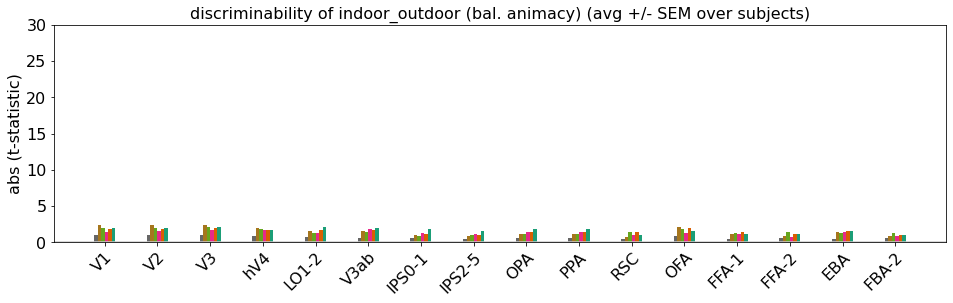

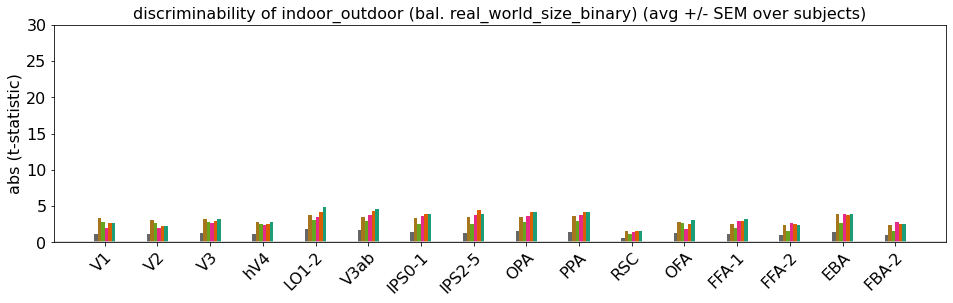

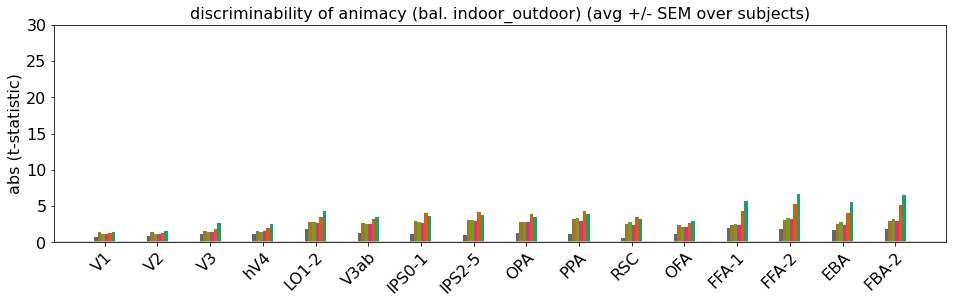

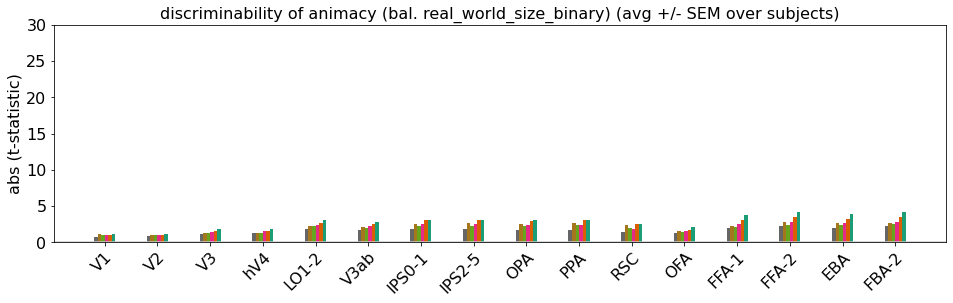

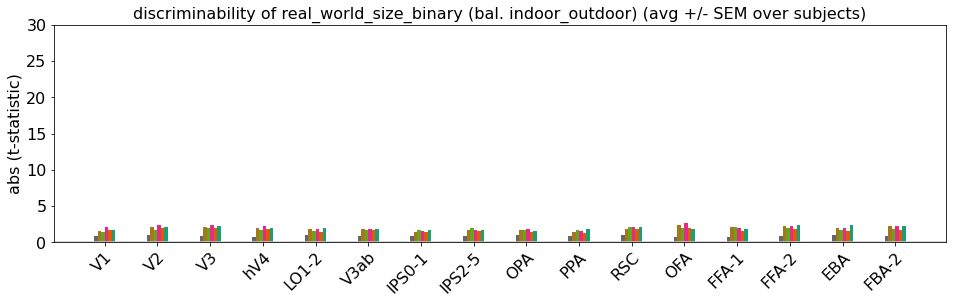

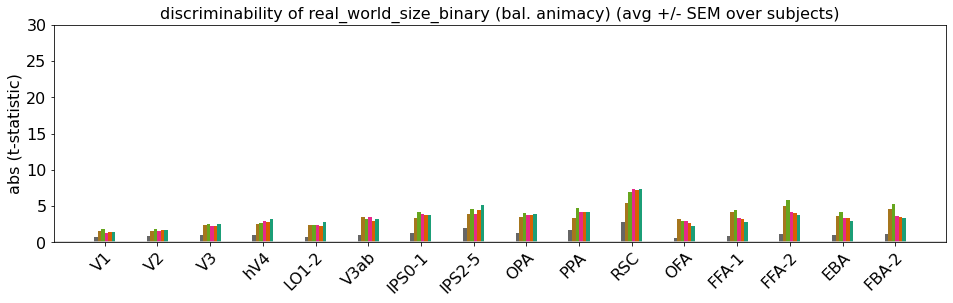

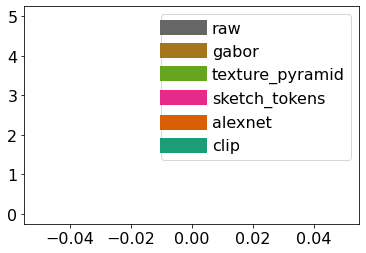

In [25]:
# plot abs tstat for higher-level categories

r2_thresh = 0.01
# r2_thresh = -10

model_colors = np.flipud(cm.Dark2(np.linspace(0,1,n_models)))

dd2plot = [0,2,1,4,3,5]

for dd in dd2plot:
    
    discrim_type = discrim_names[dd]
    
    roi_mean_vals = np.zeros((n_rois, n_models, n_subjects))
    
    for si in range(n_subjects):
        
        vox2use = clip_r2[si,0:n_voxels_each_subj[si]]>r2_thresh
        vals = np.abs(copy.deepcopy(sem_discrim[:,dd,si,0:n_voxels_each_subj[si]]))
        
        if n_levels[dd]==3:
            # only for the special case of real-world-size continuous (which has 3 levels)
            # we have an f-stat for a one-way anova instead of a t-stat. Take its square root
            # to make it comparable to the others.
            vals = np.sqrt(vals)
            
        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use
#             print(np.sum(vals[:,inds_this_roi]==0))
            
            roi_mean_vals[ri,:,si] = np.nanmean(vals[:,inds_this_roi], axis=1)
            
    mean_vals = np.mean(roi_mean_vals, axis=2)
    sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)
    
    legend_separate = (dd==len(dd2plot)-1)
    title = 'discriminability of %s (avg +/- SEM over subjects)'%(discrim_type)

    plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=model_colors, space=0.3, \
                xticklabels=roi_names, ylabel='abs (t-statistic)', \
                ylim=[0,30], title=title, horizontal_line_pos=0,\
                legend_labels=feature_type_list, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

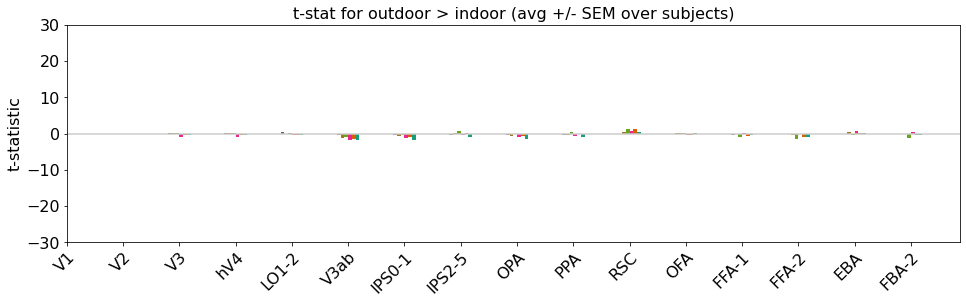

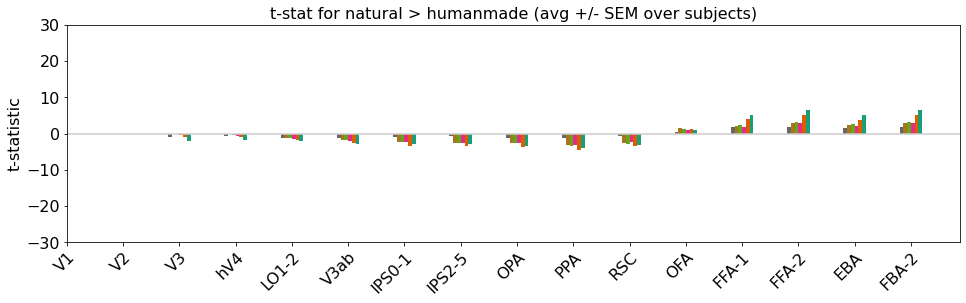

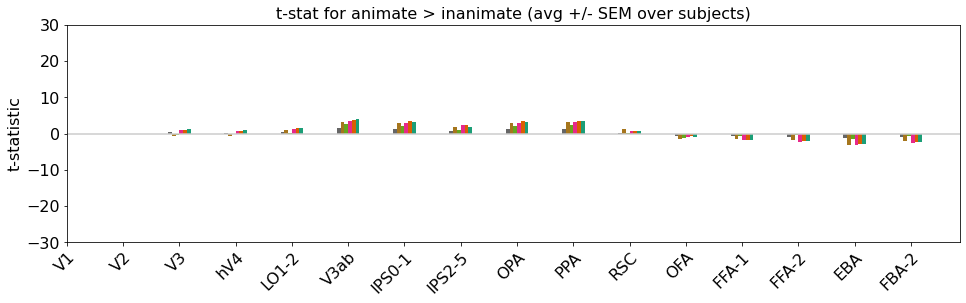

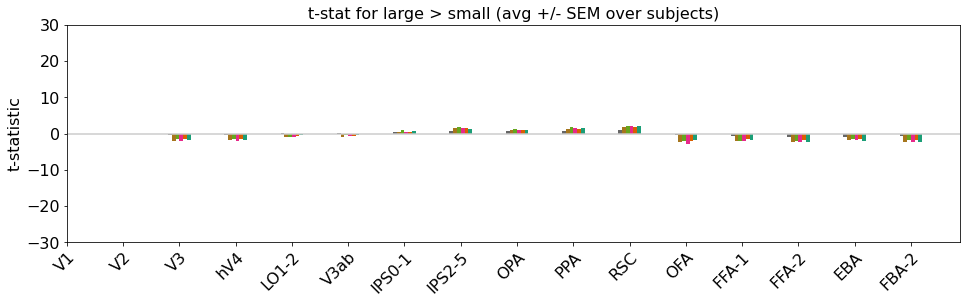

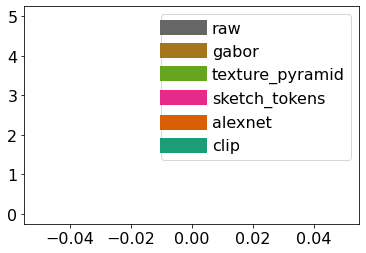

In [26]:
# plot signed tstat for higher-level categories

r2_thresh = 0.01

model_colors = np.flipud(cm.Dark2(np.linspace(0,1,n_models)))

dd2plot = [0,1,2,3]

# to make this plot easier to understand, i am flipping some of the signs so that
# they will line up more nicely. they are arbitrary, just have to keep track of which 
# sign means which category.
which_negate = [1,2]


for di, dd in enumerate(dd2plot):
    
    discrim_type = discrim_type_list[dd]
    
    roi_mean_vals = np.zeros((n_rois, n_models, n_subjects))
    
    for si in range(n_subjects):
        
        vox2use = clip_r2[si,0:n_voxels_each_subj[si]]>r2_thresh
        vals = copy.deepcopy(sem_discrim[:,dd,si,0:n_voxels_each_subj[si]])
        
        if di in which_negate:
            vals=(-1)*vals
            name = '%s > %s'%(level_names[dd][0].split('has_')[1], level_names[dd][1].split('has_')[1])
        else:
            name = '%s > %s'%(level_names[dd][1].split('has_')[1], level_names[dd][0].split('has_')[1])
            
        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use
            
            roi_mean_vals[ri,:,si] = np.mean(vals[:,inds_this_roi], axis=1)
            
    mean_vals = np.mean(roi_mean_vals, axis=2)
    sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)
    
    legend_separate = (dd==len(dd2plot)-1)
    title = 't-stat for %s (avg +/- SEM over subjects)'%(name)

    plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=model_colors, space=0.3, \
                xticklabels=roi_names, ylabel='t-statistic', \
                ylim=[-30,30], title=title, horizontal_line_pos=0,\
                legend_labels=feature_type_list, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

ValueError: could not broadcast input array from shape (2,) into shape (3,)

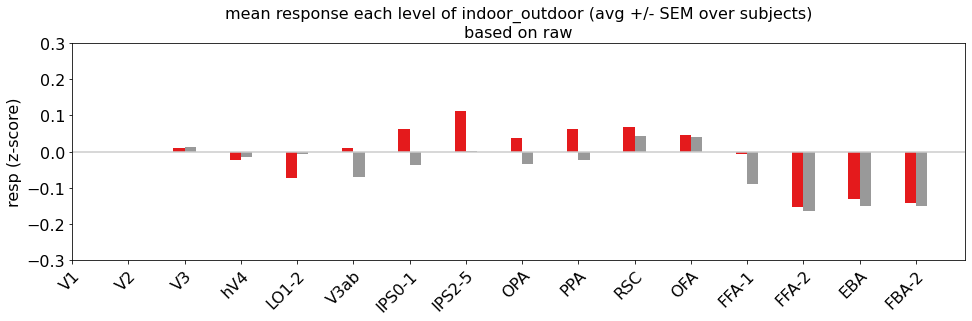

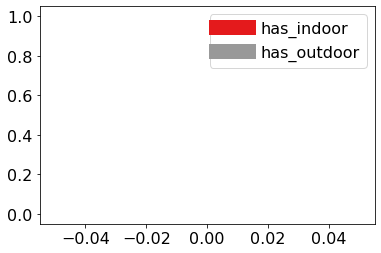

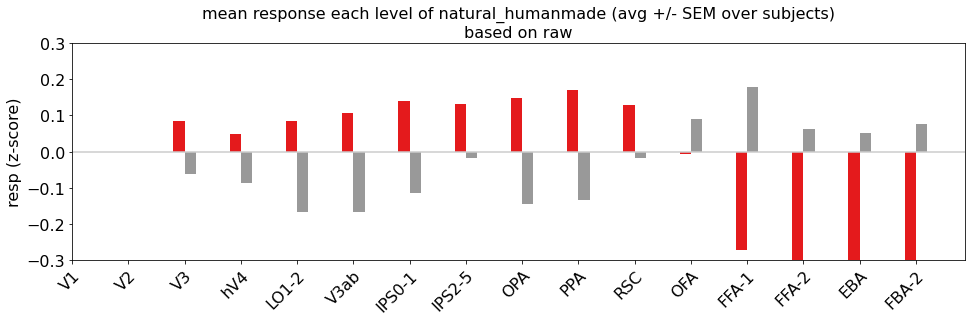

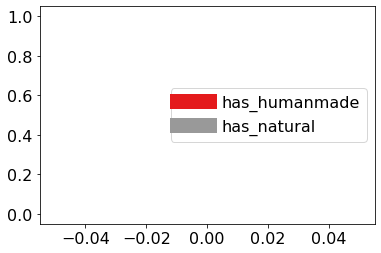

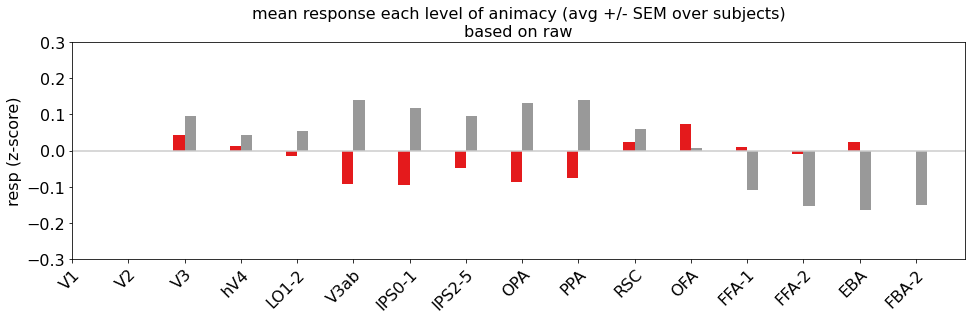

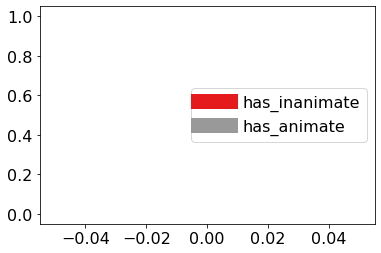

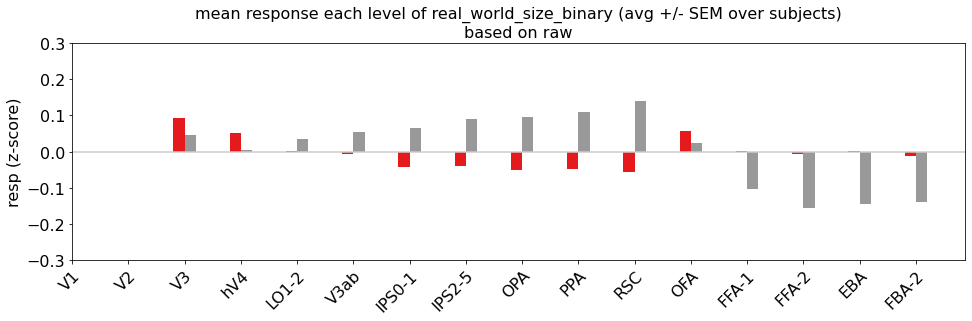

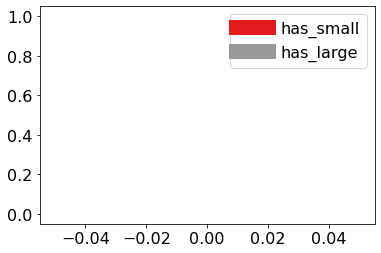

In [9]:
# plot mean of voxel's response within each "level" of the semantic discrimination of interest.
# averaged across ROIs and across subjects.

r2_thresh = 0.01

dd2plot = np.arange(5)
# dd2plot = [0]

mm = 0;
# mm = 5; # one model type at a time

# to make this plot easier to understand, i am flipping some of the signs so that
# they will line up more nicely. they are arbitrary, just have to keep track of which 
# sign means which category.
which_negate = [1,2]

for di, dd in enumerate(dd2plot):
    
    roi_mean_vals = np.zeros((n_rois, n_levels[dd], n_subjects))
       
    group_colors = cm.Set1(np.linspace(0,1,n_levels[dd]))

    discrim_type = discrim_type_list[dd]
    
    for si in range(n_subjects):
        
        vox2use = clip_r2[si,0:n_voxels_each_subj[si]]>r2_thresh
        
        # vals is [nlevels x nvoxels]
        vals = sem_means[mm,dd,0:n_levels[dd],si,0:n_voxels_each_subj[si]]
        
        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use
            
            roi_mean_vals[ri,:,si] = np.mean(vals[:,inds_this_roi], axis=1)
            
    mean_vals = np.mean(roi_mean_vals, axis=2)
    sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)
    if di in which_negate:
        names = [level_names[dd][1],level_names[dd][0]]
        mean_vals = mean_vals[:,[1,0]]
        sem_vals = sem_vals[:,[1,0]]
    else:
        names = level_names[dd]
    
    legend_separate = True
    title = 'mean response each level of %s (avg +/- SEM over subjects)\nbased on %s'\
        %(discrim_type, feature_type_list[mm])

    plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=group_colors, space=0.3, \
                xticklabels=roi_names, ylabel='resp (z-score)', \
                ylim=[-0.3,0.3], title=title, horizontal_line_pos=0,\
                legend_labels=names, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

In [16]:
[level_names[0][1],level_names[0][0]]

['has_outdoor', 'has_indoor']

In [19]:
sem_means.shape

(2, 56, 3, 8, 30000)

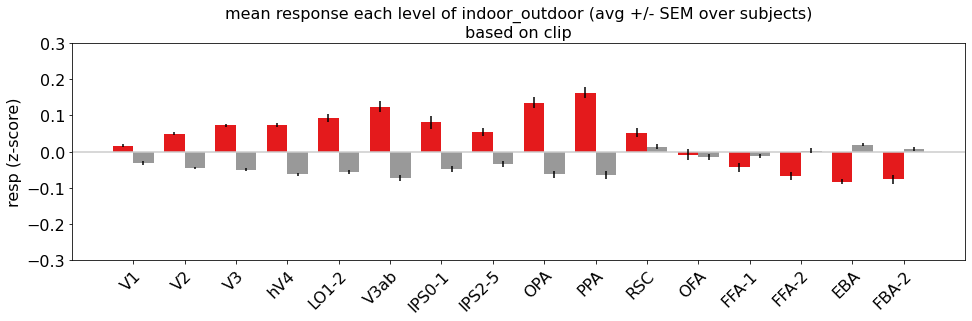

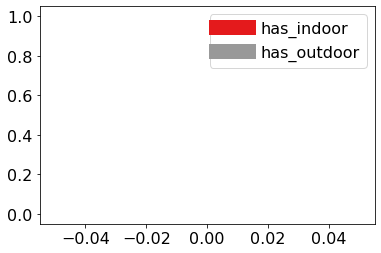

In [18]:
# plot mean of voxel's response within each "level" of the semantic discrimination of interest.
# averaged across ROIs and across subjects.

r2_thresh = 0.01

# dd2plot = np.arange(5)
dd2plot = [0]

mm = 1;
# mm = 4; # one model type at a time

for di, dd in enumerate(dd2plot):
    
    roi_mean_vals = np.zeros((n_rois, n_levels[dd], n_subjects))
       
    group_colors = cm.Set1(np.linspace(0,1,n_levels[dd]))

    discrim_type = discrim_type_list[dd]
    
    for si in range(n_subjects):
        
        vox2use = clip_r2[si,0:n_voxels_each_subj[si]]>r2_thresh
        
        # vals is [nlevels x nvoxels]
        vals = sem_means[mm,dd,0:n_levels[dd],si,0:n_voxels_each_subj[si]]
        
        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use
            
            roi_mean_vals[ri,:,si] = np.mean(vals[:,inds_this_roi], axis=1)
            
    mean_vals = np.mean(roi_mean_vals, axis=2)
    sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)
    
    legend_separate = True
    title = 'mean response each level of %s (avg +/- SEM over subjects)\nbased on %s'\
        %(discrim_type, feature_type_list[mm])

    plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=group_colors, space=0.3, \
                xticklabels=roi_names, ylabel='resp (z-score)', \
                ylim=[-0.3,0.3], title=title, horizontal_line_pos=0,\
                legend_labels=level_names[dd], \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

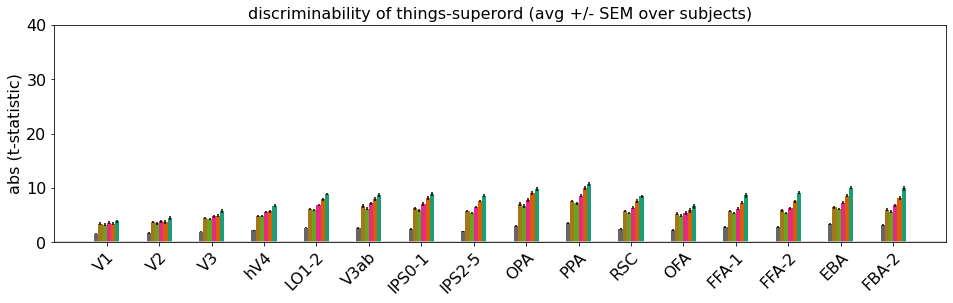

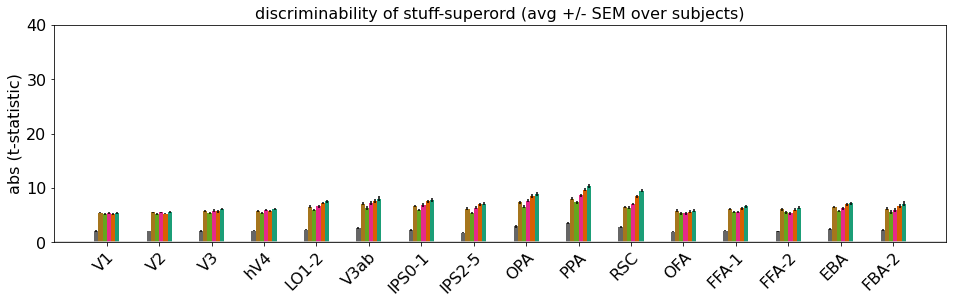

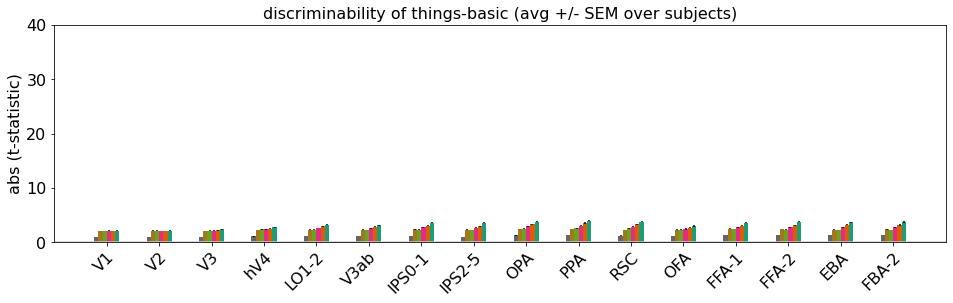

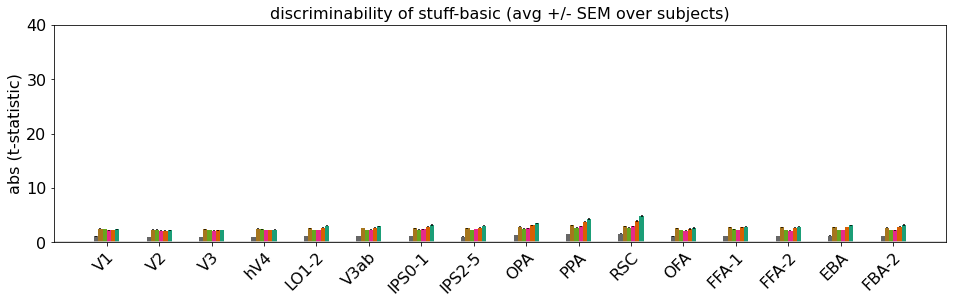

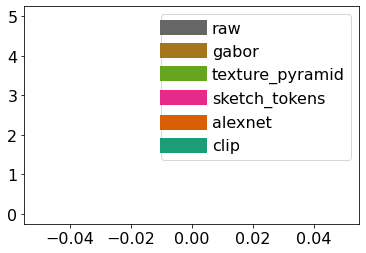

In [19]:
# plot abs tstat for lower-level discriminations (superordinate categories, and basic level)
# averaged across all different discriminations at these levels. 

r2_thresh = 0.01

model_colors = np.flipud(cm.Dark2(np.linspace(0,1,n_models)))

dd2plot = [5,6,7,8]
# dd2plot = [7]

for di, dd in enumerate(dd2plot):
    
    discrim_type = group_names[dd]
    
    roi_mean_vals = np.zeros((n_rois, n_models, n_subjects))
    
    for si in range(n_subjects):
        
        vox2use = clip_r2[si,0:n_voxels_each_subj[si]]>r2_thresh
        vals = sem_discrim_grouped[:,dd,si,0:n_voxels_each_subj[si]]
        
        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use
            
            # need a nanmean here, because there might be some voxels in an ROI where
            # there were not enough trials to evaluate any of the discriminations 
            # (it is based on where/how large these voxels' pRFs were)
            roi_mean_vals[ri,:,si] = np.nanmean(vals[:,inds_this_roi], axis=1)
            
    mean_vals = np.mean(roi_mean_vals, axis=2)
    sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)
    
    legend_separate = (di==len(dd2plot)-1)
    title = 'discriminability of %s (avg +/- SEM over subjects)'%(discrim_type)

    plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=model_colors, space=0.3, \
                xticklabels=roi_names, ylabel='abs (t-statistic)', \
                ylim=[0, 40], title=title, horizontal_line_pos=0,\
                legend_labels=feature_type_list, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

In [155]:
roi_mean_vals[0,0,:]

array([2.65875294, 2.62092605, 2.3515384 , 2.27447963, 2.74819091,
       2.26966028, 2.59664283, 2.44563714])

In [156]:
mean_vals[0,0]

2.4957285217609364

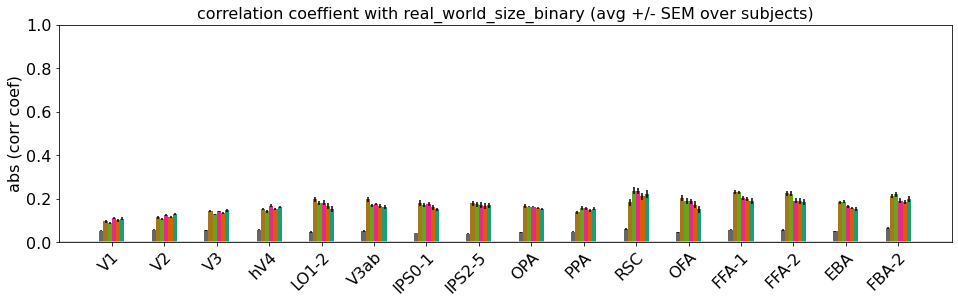

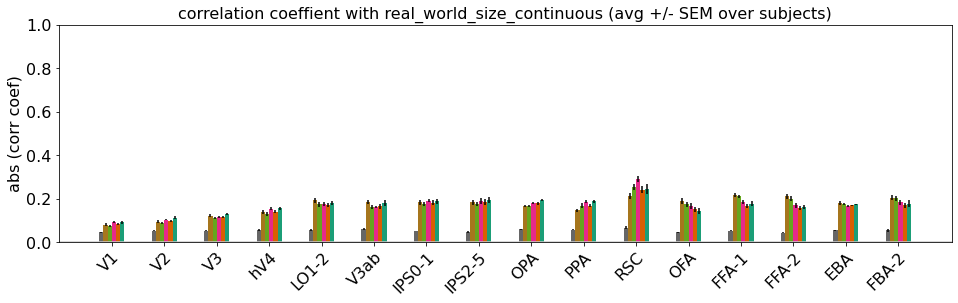

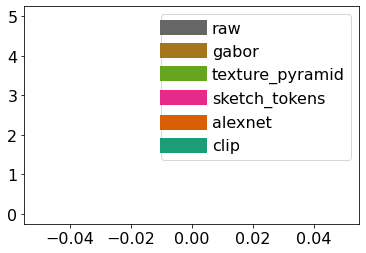

In [20]:
# plot abs correlation coefficient between semantic label/voxel resp

r2_thresh = 0.01

model_colors = np.flipud(cm.Dark2(np.linspace(0,1,n_models)))

dd2plot = [3,4]

for di,dd in enumerate(dd2plot):
    
    discrim_type = discrim_type_list[dd]
    
    roi_mean_vals = np.zeros((n_rois, n_models, n_subjects))
    
    for si in range(n_subjects):
        
        vox2use = clip_r2[si,0:n_voxels_each_subj[si]]>r2_thresh
        vals = np.abs(sem_corr[:,dd,si,0:n_voxels_each_subj[si]])
        
        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use
            
            roi_mean_vals[ri,:,si] = np.mean(vals[:,inds_this_roi], axis=1)
            
    mean_vals = np.mean(roi_mean_vals, axis=2)
    sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)
    
    legend_separate = (di==len(dd2plot)-1)
    title = 'correlation coeffient with %s (avg +/- SEM over subjects)'%(discrim_type)

    plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=model_colors, space=0.3, \
                xticklabels=roi_names, ylabel='abs (corr coef)', \
                ylim=[0, 1], title=title, horizontal_line_pos=0,\
                legend_labels=feature_type_list, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

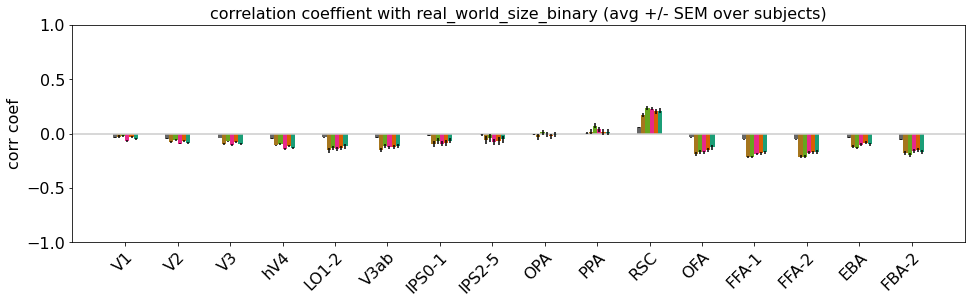

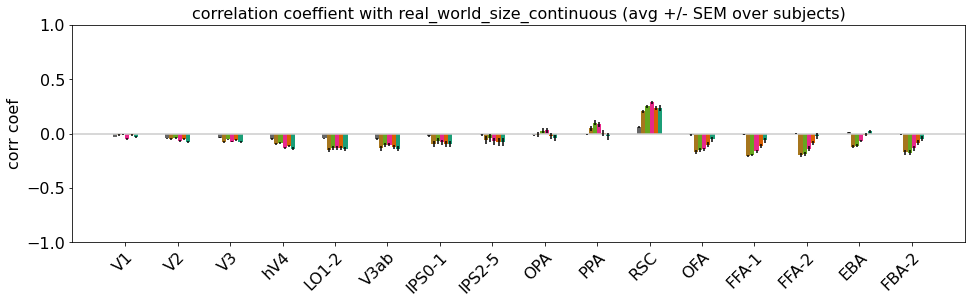

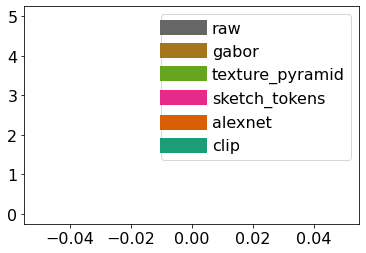

In [21]:
# plot signed correlation coefficient between semantic label/voxel resp

r2_thresh = 0.01

model_colors = np.flipud(cm.Dark2(np.linspace(0,1,n_models)))

dd2plot = [3,4]

for di, dd in enumerate(dd2plot):
    
    discrim_type = discrim_type_list[dd]
    
    roi_mean_vals = np.zeros((n_rois, n_models, n_subjects))
    
    for si in range(n_subjects):
        
        vox2use = clip_r2[si,0:n_voxels_each_subj[si]]>r2_thresh
        vals = sem_corr[:,dd,si,0:n_voxels_each_subj[si]]
        
        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use
            
            roi_mean_vals[ri,:,si] = np.mean(vals[:,inds_this_roi], axis=1)
            
    mean_vals = np.mean(roi_mean_vals, axis=2)
    sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)
    
    legend_separate = (di==len(dd2plot)-1)
    title = 'correlation coeffient with %s (avg +/- SEM over subjects)'%(discrim_type)

    plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=model_colors, space=0.3, \
                xticklabels=roi_names, ylabel='corr coef', \
                ylim=[-1, 1], title=title, horizontal_line_pos=0,\
                legend_labels=feature_type_list, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))